# Proyek Analisis Data: [E-Commerce Public Dataset]
- **Nama:** [Made Angga Danan Jaya]
- **Email:** [madeanggaa28@gmail.com]
- **ID Dicoding:** [madeangga]

## Menentukan Pertanyaan Bisnis

- Produk Mana yang Paling Banyak dan Sedikit yang Terjual?
- Bagaimana tingkat kepuasan customer terhadap layanan kami?
- Lokasi geografis yang memiliki pelanggan terbanyak?

## Import Semua Packages/Library yang Digunakan

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib
import matplotlib.image as mpimg
from scipy import stats

## Data Wrangling

### Gathering Data

In [2]:
data_directory = "dataset/"

orders_df = pd.read_csv(f"{data_directory}orders_dataset.csv")
items_df = pd.read_csv(f"{data_directory}order_items_dataset.csv")
products_df = pd.read_csv(f"{data_directory}products_dataset.csv")
payments_df = pd.read_csv(f"{data_directory}order_payments_dataset.csv")
reviews_df = pd.read_csv(f"{data_directory}order_reviews_dataset.csv")
customers_df = pd.read_csv(f"{data_directory}customers_dataset.csv")
sellers_df = pd.read_csv(f"{data_directory}sellers_dataset.csv")
geo_df = pd.read_csv(f"{data_directory}geolocation_dataset.csv")
category_df = pd.read_csv(f"{data_directory}product_category_name_translation.csv")

dataframes = {
    'orders': orders_df,
    'items': items_df,
    'products': products_df,
    'payments': payments_df,
    'reviews': reviews_df,
    'customers': customers_df,
    'sellers': sellers_df,
    'geolocation': geo_df,
    'category': category_df
}


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/orders_dataset.csv'

In [ ]:
dataframes['customers'].head()

In [ ]:
dataframes['geolocation'].head()

In [ ]:
dataframes['items'].head()

In [ ]:
dataframes['payments'].head()

In [ ]:
dataframes['reviews'].head()

In [ ]:
dataframes['orders'].head()

In [ ]:
dataframes['products'].head()

In [ ]:
dataframes['sellers'].head()

In [ ]:
dataframes['category'].head()

### Assessing Data

Memeriksa Data

In [ ]:
for name, dataframe in dataframes.items():
    print(f"\nInformasi tipe data untuk DataFrame '{name}':")
    print(dataframe.info())


Apakah ada data yang duplikat?

In [ ]:
duplicate_counts = {}
sample_counts = {}

for name, df in dataframes.items():
    duplicate_counts[name] = df.duplicated().sum()
    sample_counts[name] = df.shape[0]

duplicate_df = pd.DataFrame({
    'Total Sample Count': sample_counts,
    'Duplicate Count': duplicate_counts
})

print(duplicate_df)

Cek Nilai Yang Kemungkinan Hilang

In [ ]:
missing_values = {}


for name, dataframe in dataframes.items():
    missing_values[name] = dataframe.isnull().sum()
    print(f"DataFrame '{name}':")
    print(missing_values[name], "\n")

### Cleaning Data

Orders

In [ ]:
print(dataframes['orders']['order_status'].value_counts())

delivered_percentage = (dataframes['orders']['order_status'].value_counts()['delivered'] / len(dataframes['orders'])) * 100
print(f"Taking only delivered orders, we still get {round(delivered_percentage, 2)}% of data.")

not_delivered = dataframes['orders']['order_id'][dataframes['orders']['order_status'] != 'delivered'].values

for table_name, table in dataframes.items():
    if 'order_id' in table.columns:
        table.drop(table[table['order_id'].isin(not_delivered)].index, inplace=True)

for table_name, table in dataframes.items():
    for column in table.columns:
        missing_count = table[column].isnull().sum()
        if missing_count:
            print(f"{column} (%): {round((missing_count / len(table)) * 100, 2)}")

missing_delivery_dates = dataframes['orders']['order_id'][dataframes['orders']['order_delivered_customer_date'].isnull()].values
print(f"There are {len(missing_delivery_dates)} orders missing delivery dates.")

for table_name, table in dataframes.items():
    if 'order_id' in table.columns:
        table.drop(table[table['order_id'].isin(missing_delivery_dates)].index, inplace=True)

dataframes['orders']['delivered_on_time'] = np.where(
    dataframes['orders']['order_delivered_customer_date'] < dataframes['orders']['order_estimated_delivery_date'],
    'On Time', 'Late'
)


Reviews

In [ ]:
print('Review columns:', dataframes['reviews'].columns.values)

dataframes['reviews'].drop(['review_comment_title'], axis=1, inplace=True)

dataframes['reviews']['review_comment_message'] = np.where(
    dataframes['reviews']['review_comment_message'].isnull(), 0, 1
)

Products

In [ ]:
print('Product columns:', dataframes['products'].columns.values)

columns_to_drop = [
    'product_name_lenght', 'product_description_lenght', 'product_weight_g',
    'product_length_cm', 'product_height_cm', 'product_width_cm'
]
dataframes['products'].drop(columns_to_drop, axis=1, inplace=True)

dataframes['products']['product_category_name'].fillna('outro', inplace=True)

dataframes['products']['product_photos_qty'].fillna(0, inplace=True)

Geolocation

In [ ]:
dataframes['geolocation'].drop_duplicates(inplace=True)

## Exploratory Data Analysis (EDA)

### Explore Customer

In [ ]:
dataframes['customers'].sample(5)
dataframes['customers'].groupby('customer_city')['customer_id'].nunique().sort_values(ascending=False)
dataframes['customers'].groupby('customer_state')['customer_id'].nunique().sort_values(ascending=False)

,customer_id
customer_state,
SP,41746
RJ,12852
MG,11635
RS,5466
PR,5045
SC,3637
BA,3380
DF,2140
ES,2033


### Explore Payments

In [ ]:
dataframes['payments'].sample(5)
dataframes['payments'].groupby('payment_type')['order_id'].nunique().sort_values(ascending=False)

,order_id
payment_type,
credit_card,74297
boleto,19191
voucher,3679
debit_card,1484


### Explore Orders

In [ ]:
dataframes['orders'].sample(5)
dataframes['orders']['delivered_on_time'].describe()

,delivered_on_time
count,96470
unique,2
top,On Time
freq,88644


### Combined Customer and Order Data

Combining Customer and Order Tables

In [ ]:
customers_orders_df = pd.merge(
    left=dataframes['customers'],
    right=dataframes['orders'],
    how="left",
    on="customer_id"
)
customers_orders_df.head()


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_on_time
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,On Time
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,On Time
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,Late
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,On Time
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,On Time


Combining Payout Tables and Reviews

In [ ]:
payments_reviews_df = pd.merge(
    left=dataframes['payments'],
    right=dataframes['reviews'],
    how="left",
    on="order_id"
)
payments_reviews_df.head()

payments_reviews_df.sort_values(by="payment_value", ascending=False)

payments_reviews_df.groupby('payment_type').agg({
    "order_id": "nunique",
    "payment_value": ["min", "max"]
})

order_id payment_value          
              nunique           min       max
payment_type                                 
boleto          19191         11.62   7274.88
credit_card     74297          0.01  13664.08
debit_card       1484         13.38   4445.50
voucher          3679          0.00   1839.05

Combining Customer-Order and Payment-Review Data

In [ ]:
customers_df = pd.merge(
    left=customers_orders_df,
    right=payments_reviews_df,
    how="left",
    on="order_id"
)
customers_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,delivered_on_time,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,On Time,1.0,credit_card,2.0,146.87,88b8b52d46df026a9d1ad2136a59b30b,4.0,0.0,2017-05-26 00:00:00,2017-05-30 22:34:40
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,On Time,1.0,credit_card,8.0,335.48,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,0.0,2018-01-30 00:00:00,2018-02-10 22:43:29
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,Late,1.0,credit_card,7.0,157.73,5ad6695d76ee186dc473c42706984d87,5.0,0.0,2018-06-15 00:00:00,2018-06-15 12:10:59
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,On Time,1.0,credit_card,1.0,173.30,059a801bb31f6aab2266e672cab87bc5,5.0,0.0,2018-03-29 00:00:00,2018-04-02 18:36:47
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,On Time,1.0,credit_card,8.0,252.25,8490879d58d6c5d7773f2739a03f089a,5.0,1.0,2018-08-10 00:00:00,2018-08-17 01:59:52


## Explore Items & Sellers

Combining Items and Sellers

In [ ]:
item_seller_df = pd.merge(
    left=dataframes['items'],
    right=dataframes['sellers'],
    how="left",
    on="seller_id"
)
item_seller_df.head()

item_seller_df.groupby('seller_city')['seller_id'].nunique().sort_values(ascending=False).head(10)

item_seller_df.groupby('seller_state')['seller_id'].nunique().sort_values(ascending=False).head(10)


,seller_id
seller_state,
SP,1769
PR,335
MG,236
SC,184
RJ,163
RS,125
GO,39
DF,30
ES,22


Combining Products and Categories

In [ ]:
product_df = pd.merge(
    left=dataframes['products'],
    right=dataframes['category'],
    how="left",
    on="product_category_name"
)
product_df.head()

product_df.groupby('product_category_name')['product_id'].nunique().sort_values(ascending=False).head(10)
product_df.groupby('product_category_name_english')['product_id'].nunique().sort_values(ascending=False).head(10)


,product_id
product_category_name_english,
bed_bath_table,3029
sports_leisure,2867
furniture_decor,2657
health_beauty,2444
housewares,2335
auto,1900
computers_accessories,1639
toys,1411
watches_gifts,1329


Combining Product and Item-Seller Data

In [ ]:
sellers_df = pd.merge(
    left=product_df,
    right=item_seller_df,
    how="left",
    on="product_id"
)
sellers_df.head()

sellers_df.sort_values(by="price", ascending=False)

sellers_df.groupby('product_category_name_english').agg({
    "order_id": "nunique",
    "price": ["min", "max"]
})

order_id  price         
                               nunique    min      max
product_category_name_english                         
agro_industry_and_commerce         177  12.99  2990.00
air_conditioning                   246  10.90  1599.00
art                                195   5.35  6499.00
arts_and_craftmanship               23   9.80   289.49
audio                              348  14.90   598.99
...                                ...    ...      ...
stationery                        2264   2.29  1693.00
tablets_printing_image              79  14.90   889.99
telephony                         4093   5.00  2428.00
toys                              3803   4.90  1699.99
watches_gifts                     5493   8.99  3999.90

[71 rows x 3 columns]

### Analisis Data Geolokasi

In [ ]:
dataframes['geolocation'].sample(5)
dataframes['geolocation'].groupby('geolocation_zip_code_prefix').size().sort_values(ascending=False)
dataframes['geolocation'][dataframes['geolocation']['geolocation_zip_code_prefix'] == 24230].head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
470806,24230,-22.911270,-43.105151,niterói,RJ
470807,24230,-22.905032,-43.114682,niterói,RJ
470810,24230,-22.909753,-43.101880,niteroi,RJ
470816,24230,-22.908945,-43.108600,niteroi,RJ
470817,24230,-22.906274,-43.103573,niteroi,RJ


### Combining All Data

In [ ]:
all_data = pd.merge(
    left=customers_df,
    right=sellers_df,
    how="left",
    on="order_id"
)
all_data.head(20)

all_data_df = all_data.drop_duplicates('order_id')
all_data_df.info()

all_data.groupby('product_category_name_english').agg({
    "order_id": "nunique",
    "review_score": ["min", "max"]
})


<class 'pandas.core.frame.DataFrame'>
Index: 96471 entries, 0 to 2305341
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    96471 non-null  object 
 1   customer_unique_id             96471 non-null  object 
 2   customer_zip_code_prefix       96471 non-null  int64  
 3   customer_city                  96471 non-null  object 
 4   customer_state                 96471 non-null  object 
 5   order_id                       96470 non-null  object 
 6   order_status                   96470 non-null  object 
 7   order_purchase_timestamp       96470 non-null  object 
 8   order_approved_at              96456 non-null  object 
 9   order_delivered_carrier_date   96469 non-null  object 
 10  order_delivered_customer_date  96470 non-null  object 
 11  order_estimated_delivery_date  96470 non-null  object 
 12  delivered_on_time              96470 non-null  ob

order_id review_score     
                               nunique          min  max
product_category_name_english                           
agro_industry_and_commerce         177          1.0  5.0
air_conditioning                   246          1.0  5.0
art                                195          1.0  5.0
arts_and_craftmanship               23          1.0  5.0
audio                              348          1.0  5.0
...                                ...          ...  ...
stationery                        2264          1.0  5.0
tablets_printing_image              79          1.0  5.0
telephony                         4093          1.0  5.0
toys                              3803          1.0  5.0
watches_gifts                     5493          1.0  5.0

[71 rows x 3 columns]

### Menyimpan Data

In [ ]:
output_directory = "output/"

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_csv_path = os.path.join(output_directory, "df.csv")
all_data_df.to_csv(output_csv_path, index=False)

print(f"File berhasil disimpan di: {output_csv_path}")


File berhasil disimpan di: output/df.csv


## Visualization & Explanatory Analysis

### Pertanyaan 1: Produk Mana yang Paling Banyak dan Sedikit yang Terjual?

In [ ]:
sum_order_items_df = all_data.groupby("product_category_name_english")["product_id"].count().reset_index()
sum_order_items_df = sum_order_items_df.rename(columns={"product_id": "products"})
sum_order_items_df = sum_order_items_df.sort_values(by="products", ascending=False)
sum_order_items_df = sum_order_items_df.head(10)

sum_order_items_df.head()

,product_category_name_english,products
39,furniture_decor,198787
49,housewares,164659
43,health_beauty,149453
65,sports_leisure,145456
5,auto,143938


<ipython-input-85-4360e37acd5f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="products", y="product_category_name_english", data=sum_order_items_df.head(5), palette=colors, ax=ax[0])
<ipython-input-85-4360e37acd5f>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="products", y="product_category_name_english", data=sum_order_items_df.sort_values(by="products", ascending=True).head(5), palette=colors, ax=ax[1])


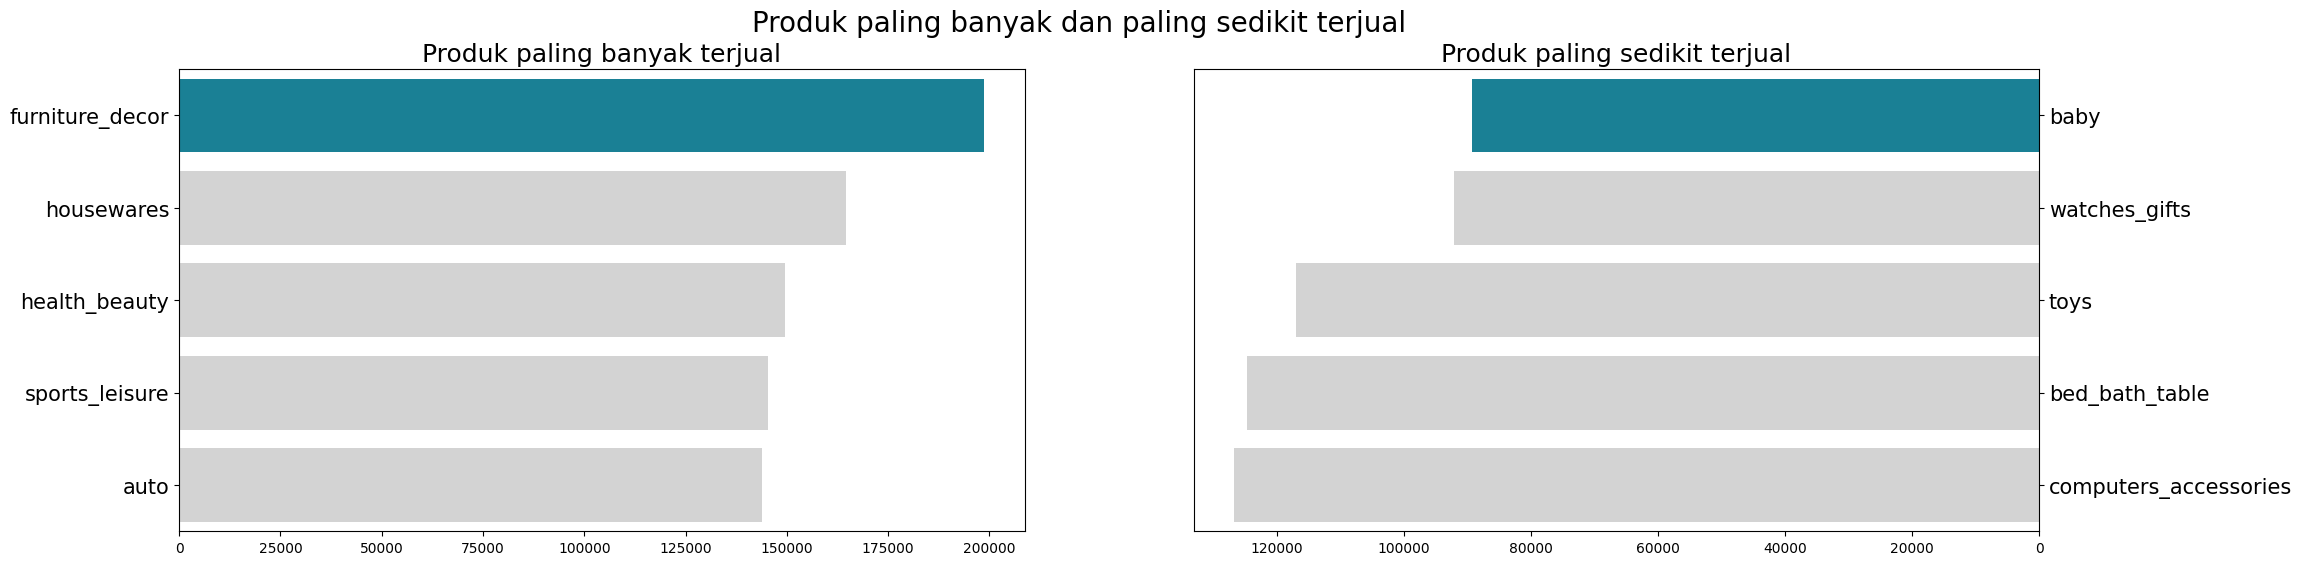

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

colors = ["#068DA9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]

sns.barplot(x="products", y="product_category_name_english", data=sum_order_items_df.head(5), palette=colors, ax=ax[0])
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title("Produk paling banyak terjual", loc="center", fontsize=18)
ax[0].tick_params(axis ='y', labelsize=15)

sns.barplot(x="products", y="product_category_name_english", data=sum_order_items_df.sort_values(by="products", ascending=True).head(5), palette=colors, ax=ax[1])
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_title("Produk paling sedikit terjual", loc="center", fontsize=18)
ax[1].tick_params(axis='y', labelsize=15)

plt.suptitle("Produk paling banyak dan paling sedikit terjual", fontsize=20)
plt.show()

Produk dalam kategori "furniture_decor" mendominasi penjualan, sementara kategori "baby" memiliki performa penjualan yang paling rendah.

### Pertanyaan 2: Bagaimana tingkat kepuasan customer terhadap layanan kami?

<ipython-input-87-c64cc10a2977>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=review_scores.index,


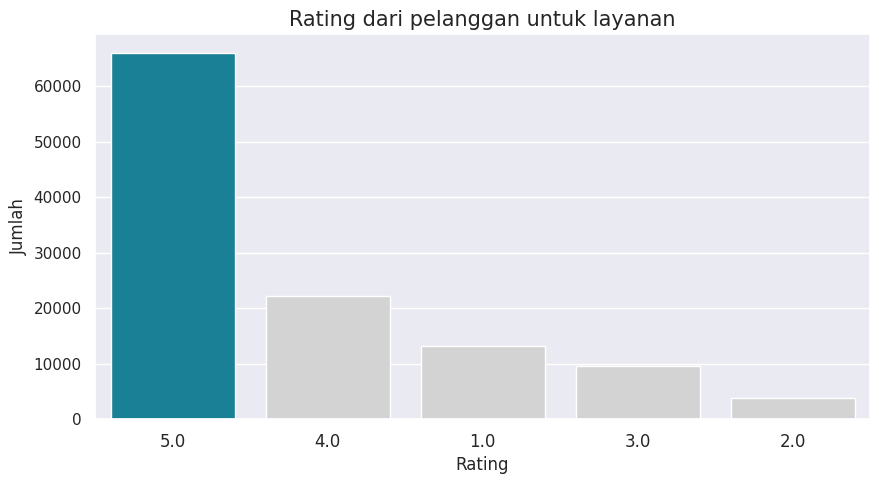

In [ ]:
review_scores = all_data['review_score'].value_counts().sort_values(ascending=False)

most_common_score = review_scores.idxmax()

sns.set(style="darkgrid")

plt.figure(figsize=(10, 5))
sns.barplot(x=review_scores.index,
            y=review_scores.values,
            order=review_scores.index,
            palette=["#068DA9" if score == most_common_score else "#D3D3D3" for score in review_scores.index]
            )

plt.title("Rating dari pelanggan untuk layanan", fontsize=15)
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.xticks(fontsize=12)

plt.show()


Grafik di atas menunjukkan bahwa pelanggan sangat puas dengan layanan yang diberikan, hal ini terbukti dari jumlah pelanggan yang memberikan rating 5, yang lebih banyak dibandingkan dengan rating lainnya.

# Pertanyaan 3: Lokasi geografis yang memiliki pelanggan terbanyak?

In [ ]:
other_state_geolocation = geo_df.groupby(['geolocation_zip_code_prefix'])['geolocation_state'].nunique().reset_index(name='count')
other_state_geolocation[other_state_geolocation['count']>= 2].shape
max_state = geo_df.groupby(['geolocation_zip_code_prefix','geolocation_state']).size().reset_index(name='count').drop_duplicates(subset = 'geolocation_zip_code_prefix').drop('count',axis=1)

geolocation_silver = geo_df.groupby(['geolocation_zip_code_prefix','geolocation_city','geolocation_state'])[['geolocation_lat','geolocation_lng']].median().reset_index()
geolocation_silver = geolocation_silver.merge(max_state,on=['geolocation_zip_code_prefix','geolocation_state'],how='inner')

customers_silver = customers_df.merge(geolocation_silver,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix',how='inner')

customers_silver.head()
customers_silver.to_csv("output/geolocation.csv", index=False)

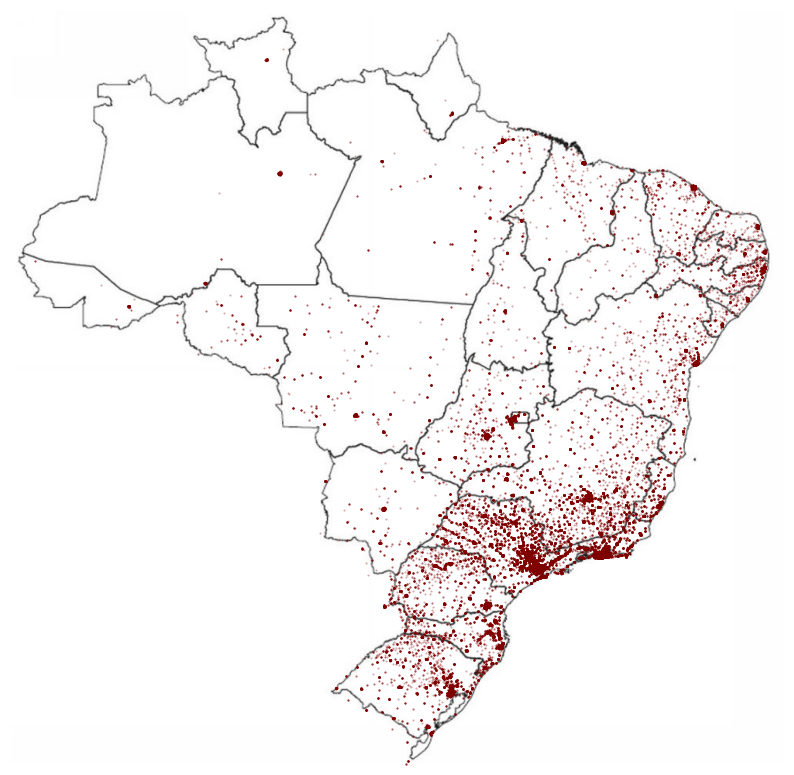

In [ ]:
def plot_brazil_map(data):
    brazil = mpimg.imread(urllib.request.urlopen('https://i.pinimg.com/originals/3a/0c/e1/3a0ce18b3c842748c255bc0aa445ad41.jpg'),'jpg')
    ax = data.plot(kind="scatter", x="geolocation_lng", y="geolocation_lat", figsize=(10,10), alpha=0.3,s=0.3,c='maroon')
    plt.axis('off')
    plt.imshow(brazil, extent=[-73.98283055, -33.8,-33.75116944,5.4])
    plt.show()


plot_brazil_map(customers_silver.drop_duplicates(subset='customer_unique_id'))

Mayoritas pelanggan berasal dari wilayah negara bagian tenggara dan selatan.

## Conclusion

- Produk Mana yang Paling Banyak dan Sedikit yang Terjual?
- Bagaimana tingkat kepuasan customer terhadap layanan kami?
- Lokasi geografis yang memiliki pelanggan terbanyak?

- Berdasarkan visualisasi data, produk **furniture_decor** menjadi kategori dengan penjualan tertinggi, diikuti oleh **housewares** dan **health_beauty**. Sementara itu, produk dengan penjualan paling rendah adalah kategori **baby**, disusul oleh **watches_gifts** dan **toys**. Hal ini menunjukkan bahwa permintaan untuk produk dekorasi dan perabot rumah tangga jauh lebih tinggi dibandingkan dengan produk bayi dan hadiah.

- Mayoritas pelanggan memberikan rating **5.0**, menunjukkan kepuasan tinggi terhadap layanan. Rating rendah seperti **1.0** dan **2.0** jumlahnya sangat sedikit.

- Pelanggan terbanyak berada di **wilayah tenggara Brasil**, terutama di negara bagian **São Paulo**, **Rio de Janeiro**, dan sekitarnya, ditunjukkan oleh kepadatan titik merah yang tinggi.